# simple conclusions after first data explorations
1. brochure_views:
    - missing duration values
    - negative values
    - data duration, page_turn_count,  not normalized
2. app_starts:
    - duplicated values
    - inconsistent values with installs data

In [27]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR = os.path.abspath("..")
RAW_DATA_PATH = os.path.join(BASE_DIR, "dataset")

In [2]:
installs = pd.read_csv(os.path.join(RAW_DATA_PATH, "installs.txt"), sep="\t")
brochure_views = pd.read_csv(os.path.join(RAW_DATA_PATH, "brochure views.txt"), sep="\t")
brochure_views_july = pd.read_csv(os.path.join(RAW_DATA_PATH, "brochure views july.txt"), sep="\t")
app_starts = pd.read_csv(os.path.join(RAW_DATA_PATH, "app starts.txt"), sep="\t")
app_starts_july = pd.read_csv(os.path.join(RAW_DATA_PATH, "app starts july.txt"), sep="\t")

In [3]:
installs['InstallDate'] = pd.to_datetime(installs['InstallDate'], errors='coerce')
brochure_views['dateCreated'] = pd.to_datetime(brochure_views['dateCreated'], errors='coerce')
brochure_views_july['dateCreated'] = pd.to_datetime(brochure_views_july['dateCreated'], errors='coerce')
app_starts['dateCreated'] = pd.to_datetime(app_starts['dateCreated'], errors='coerce')
app_starts_july['dateCreated'] = pd.to_datetime(app_starts_july['dateCreated'], errors='coerce')

# replacing missing and negative values with min nun negative value and normalization

In [4]:

min_value = brochure_views['view_duration'][brochure_views['view_duration']>0].min()
brochure_views["view_duration"] = np.where(
    (brochure_views["view_duration"] < 0) | (brochure_views["view_duration"].isnull()),
    1000,
    brochure_views["view_duration"]
)
brochure_views_july["view_duration"] = np.where(
    (brochure_views_july["view_duration"] < 0) | (brochure_views_july["view_duration"].isnull()),
    1000,
    brochure_views_july["view_duration"]
)
normalize_col = ['view_duration', 'page_turn_count']
for col in normalize_col:
    brochure_views[f'{col}_log'] = np.log1p(brochure_views[col])
    brochure_views_july[f'{col}_log'] = np.log1p(brochure_views_july[col])

# remove duplications and inconsistent data

In [5]:
app_starts.drop_duplicates(inplace=True)
app_starts = app_starts.merge(installs[['userId', 'InstallDate']], on='userId', how='left')
app_starts['dateCreated'] = app_starts[['dateCreated', 'InstallDate']].max(axis=1)
app_starts.drop(columns=['InstallDate'], inplace=True)
app_starts.head()

,dateCreated,userId
0,2017-06-30 14:14:54.793,50e72534-a4f4-40d7-96d5-ecbe4eb314e9
1,2017-06-30 14:03:13.010,b3712849-595e-403f-84d2-4698439056b0
2,2017-06-28 16:26:48.383,99cea50b-3ecf-4102-8290-997eaf32a6b6
3,2017-06-27 10:23:29.943,78c06433-9ea8-4835-aff5-f64b262d0fb4
4,2017-06-27 10:11:27.634,510c5f9e-de54-45ee-909c-c14103130e5e


In [11]:
installs.head()
app_starts_july.head()
app_starts_july.drop(columns=['InstallDate_x'], inplace=True)
app_starts_july.drop(columns=['InstallDate_y'], inplace=True)

In [12]:
app_starts_july.drop_duplicates(inplace=True)
app_starts_july = app_starts_july.merge(installs[['userId', 'InstallDate']], on='userId', how='left')
app_starts_july['dateCreated'] = app_starts_july[['dateCreated', 'InstallDate']].max(axis=1)
app_starts_july.drop(columns=['InstallDate'], inplace=True)

# visualization after cleaning

array([[<Axes: title={'center': 'view_duration_log'}>,
        <Axes: title={'center': 'page_turn_count_log'}>]], dtype=object)

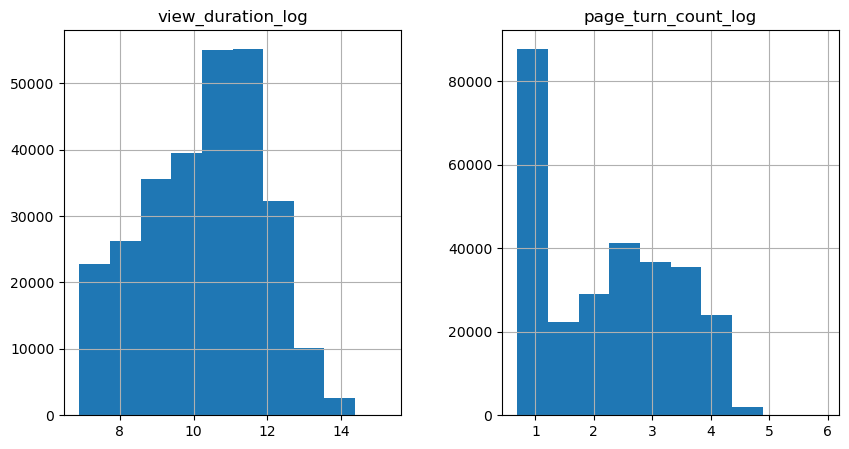

In [14]:
# impact of log transfer
brochure_views[['view_duration_log', 'page_turn_count_log']].hist(figsize=(10, 5))

In [15]:
print(app_starts[app_starts['dateCreated'].isnull()].shape)
print(app_starts_july[app_starts_july['dateCreated'].isnull()].shape)

(0, 2)
(0, 2)


In [20]:
print("\nBrochure Views Describe:\n")
display (brochure_views.describe())


Brochure Views Describe:



,id,dateCreated,page_turn_count,view_duration,brochure_id,view_duration_log,page_turn_count_log
count,2.792130e+05,279213,279213.000000,2.792130e+05,2.792130e+05,279213.000000,279213.000000
mean,6.546832e+09,2017-05-20 18:19:11.878093312,15.830352,8.440337e+04,6.746679e+08,10.282973,2.187518
min,5.709034e+09,2017-04-01 00:29:01.711000,1.000000,1.000000e+03,5.416142e+08,6.908755,0.693147
25%,6.269143e+09,2017-05-02 17:02:28.992999936,1.000000,9.000000e+03,6.678938e+08,9.105091,0.693147
50%,6.570289e+09,2017-05-21 22:50:47.904999936,9.000000,3.600000e+04,6.780668e+08,10.491302,2.302585
75%,6.834928e+09,2017-06-08 02:00:10.892999936,23.000000,9.800000e+04,6.851689e+08,11.492733,3.178054
max,7.216487e+09,2017-06-30 23:59:53.699000,375.000000,4.009200e+06,6.995658e+08,15.204103,5.929589
std,3.642842e+08,NaN,18.688516,1.494579e+05,1.616983e+07,1.612720,1.181055


In [48]:
from src.genral import save_dataframes_to_pickle
dataframes = [installs, brochure_views, brochure_views_july, app_starts, app_starts_july]
file_names = ['installs.pkl', 'brochure_views.pkl', 'brochure_views_july.pkl', 'app_starts.pkl', 'app_starts_july.pkl']
SAVE_CLEAN_DATA_PATH = os.path.join(BASE_DIR, "data", "clean_data")

save_dataframes_to_pickle(dataframes, file_names, SAVE_CLEAN_DATA_PATH)


File saved successfully: C:\Users\mona1\PycharmProjects\scientificProject\data\clean_data\installs.pkl
File saved successfully: C:\Users\mona1\PycharmProjects\scientificProject\data\clean_data\brochure_views.pkl
File saved successfully: C:\Users\mona1\PycharmProjects\scientificProject\data\clean_data\brochure_views_july.pkl
File saved successfully: C:\Users\mona1\PycharmProjects\scientificProject\data\clean_data\app_starts.pkl
File saved successfully: C:\Users\mona1\PycharmProjects\scientificProject\data\clean_data\app_starts_july.pkl


# Time-sires analysis

In [22]:
earliest_date = brochure_views['dateCreated'].min()
latest_date = brochure_views['dateCreated'].max()

print("Earliest brochure view date:", earliest_date)
print("Latest brochure view date:", latest_date)

Earliest brochure view date: 2017-04-01 00:29:01.711000
Latest brochure view date: 2017-06-30 23:59:53.699000


In [42]:
user_date_range = brochure_views.groupby(['userId','brochure_id']).agg(
    earliest_view=('dateCreated', 'min'),
   latest_view=('dateCreated', 'max'),
    total_duration=('view_duration_log', 'sum'),
    avg_duration=('view_duration_log', 'mean'),
    total_pages=('page_turn_count_log', 'sum')
).reset_index()
user_date_range['view_duration_days'] =np.log1p((user_date_range['latest_view']-user_date_range['earliest_view']).dt.days)

display(user_date_range.head())

print("Number of users with view data:", user_date_range.shape[0])

,userId,brochure_id,earliest_view,latest_view,total_duration,avg_duration,total_pages,view_duration_days
0,0002C218-D30F-402E-AE08-1280AD4FB669,541614364,2017-04-26 03:46:08.280,2017-04-26 03:46:08.280,7.601402,7.601402,0.693147,0.0
1,0002C218-D30F-402E-AE08-1280AD4FB669,631731945,2017-04-24 22:45:25.966,2017-04-24 22:45:25.966,11.835016,11.835016,3.713572,0.0
2,0002C218-D30F-402E-AE08-1280AD4FB669,657370331,2017-04-26 03:46:20.008,2017-04-26 03:46:20.008,10.239996,10.239996,3.218876,0.0
3,0002C218-D30F-402E-AE08-1280AD4FB669,665488997,2017-04-26 03:39:55.547,2017-04-26 03:39:55.547,8.853808,8.853808,1.098612,0.0
4,0002C218-D30F-402E-AE08-1280AD4FB669,665489007,2017-04-28 19:02:13.400,2017-04-28 19:02:13.400,8.853808,8.853808,1.098612,0.0


Number of users with view data: 197839


In [47]:
grouped_by_day = brochure_views.groupby(['userId', 'brochure_id', 'dateCreated']).agg(
    total_views=('view_duration_log', 'count'),
    total_duration=('view_duration_log', 'sum'),
    average_duration=('view_duration_log', 'mean')
).reset_index()
display(grouped_by_day.head())

print("Number of users with view data:", grouped_by_day.shape[0])
print(grouped_by_day['average_duration'].unique().shape[0])


,userId,brochure_id,dateCreated,total_views,total_duration,average_duration
0,0002C218-D30F-402E-AE08-1280AD4FB669,541614364,2017-04-26 03:46:08.280,1,7.601402,7.601402
1,0002C218-D30F-402E-AE08-1280AD4FB669,631731945,2017-04-24 22:45:25.966,1,11.835016,11.835016
2,0002C218-D30F-402E-AE08-1280AD4FB669,657370331,2017-04-26 03:46:20.008,1,10.239996,10.239996
3,0002C218-D30F-402E-AE08-1280AD4FB669,665488997,2017-04-26 03:39:55.547,1,8.853808,8.853808
4,0002C218-D30F-402E-AE08-1280AD4FB669,665489007,2017-04-28 19:02:13.400,1,8.853808,8.853808


Number of users with view data: 279197
9714


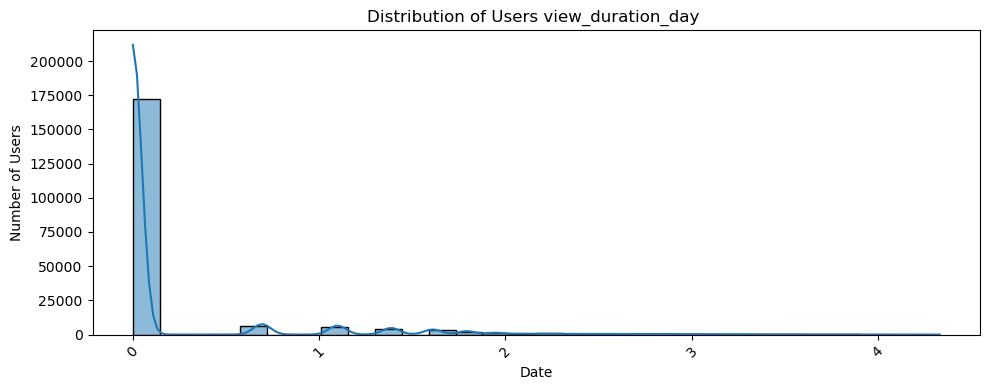

In [37]:
plt.figure(figsize=(10,4))
sns.histplot(user_date_range['view_duration_days'], kde=True, bins=30)
plt.title("Distribution of Users view_duration_day ")
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

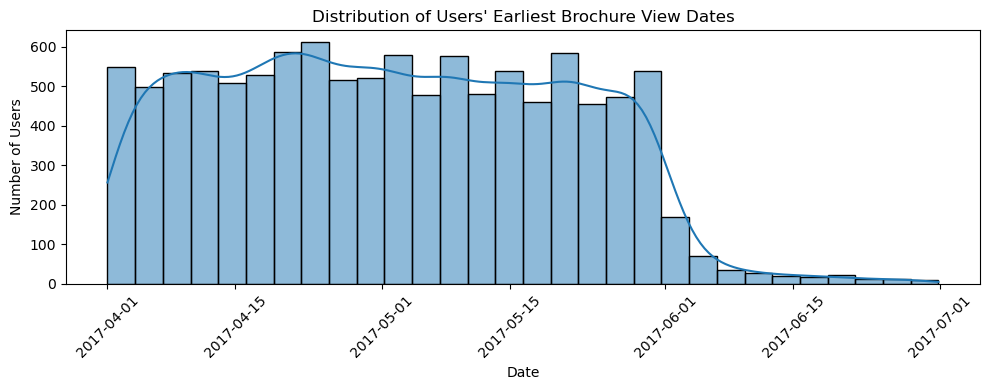

In [29]:
plt.figure(figsize=(10,4))
sns.histplot(user_date_range['earliest_view'], kde=True, bins=30)
plt.title("Distribution of Users' Earliest Brochure View Dates")
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

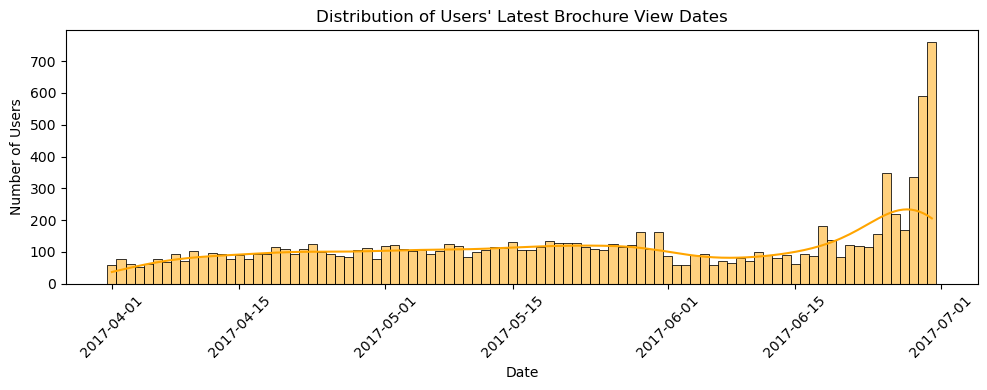

In [30]:
user_date_range['latest_view'] = user_date_range['latest_view'].dt.date

plt.figure(figsize=(10,4))
sns.histplot(user_date_range['latest_view'], kde=True, bins=30, color='orange')
plt.title("Distribution of Users' Latest Brochure View Dates")
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()